In [1]:
import sys
sys.path.append('C:\\Users\\Yonatan Gideoni\\Desktop\\ML4Q\\c3')

Code mostly taken from <code>two_qubits.ipynb</code>

#### Imports

In [2]:
# System imports
import copy
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from pprint import pprint

# Main C3 objects
from c3.c3objs import Quantity as Qty
from c3.parametermap import ParameterMap as PMap
from c3.experiment import Experiment as Exp
from c3.model import Model as Mdl
from c3.generator.generator import Generator as Gnr

# Building blocks
import c3.generator.devices as devices
import c3.signal.gates as gates
import c3.libraries.chip as chip
import c3.signal.pulse as pulse
import c3.libraries.tasks as tasks

# Libs and helpers
import c3.libraries.algorithms as algorithms
import c3.libraries.hamiltonians as hamiltonians
import c3.libraries.fidelities as fidelities
import c3.libraries.envelopes as envelopes

# Qiskit related modules
from c3.qiskit import C3Provider
from c3.qiskit.c3_gates import RX90pGate
from qiskit import QuantumCircuit, Aer, execute
from qiskit.tools.visualization import plot_histogram

#### Model components

In [3]:
qubit_lvls = 3
freq_q1 = 5e9
anhar_q1 = -210e6
t1_q1 = 27e-6
t2star_q1 = 39e-6
qubit_temp = 50e-3

q1 = chip.Qubit(
    name="Q1",
    desc="Qubit 1",
    freq=Qty(
        value=freq_q1,
        min_val=4.995e9 ,
        max_val=5.005e9 ,
        unit='Hz 2pi'
    ),
    anhar=Qty(
        value=anhar_q1,
        min_val=-380e6 ,
        max_val=-20e6 ,
        unit='Hz 2pi'
    ),
    hilbert_dim=qubit_lvls,
    t1=Qty(
        value=t1_q1,
        min_val=1e-6,
        max_val=90e-6,
        unit='s'
    ),
    t2star=Qty(
        value=t2star_q1,
        min_val=10e-6,
        max_val=90e-3,
        unit='s'
    ),
    temp=Qty(
        value=qubit_temp,
        min_val=0.0,
        max_val=0.12,
        unit='K'
    )
)

In [4]:
drive = chip.Drive(
    name="d1",
    desc="Drive 1",
    comment="Drive line 1 on qubit 1",
    connected=["Q1"],
    hamiltonian_func=hamiltonians.x_drive
)

The following task creates an initial thermal state with given temperature.

In [5]:
init_temp = 50e-3
init_ground = tasks.InitialiseGround(
    init_temp=Qty(
        value=init_temp,
        min_val=-0.001,
        max_val=0.22,
        unit='K'
    )
)

We collect the parts specified above in the Model.

In [6]:
model = Mdl(
    [q1], # Individual, self-contained components
    [drive],  # Interactions between components
)

Further, we can decide between coherent or open-system dynamics using set_lindbladian() and whether to eliminate the static coupling by going to the dressed frame with set_dressed().

In [7]:
model.set_lindbladian(False)
model.set_dressed(True)

#### Control signals

In [8]:
sim_res = 100e9 # Resolution for numerical simulation
awg_res = 2e9 # Realistic, limited resolution of an AWG
lo = devices.LO(name='lo', resolution=sim_res)
awg = devices.AWG(name='awg', resolution=awg_res)
mixer = devices.Mixer(name='mixer')

In [9]:
dig_to_an = devices.DigitalToAnalog(
    name="dac",
    resolution=sim_res
)
v2hz = 1e9
v_to_hz = devices.VoltsToHertz(
    name='v_to_hz',
    V_to_Hz=Qty(
        value=v2hz,
        min_val=0.9e9,
        max_val=1.1e9,
        unit='Hz/V'
    )
)

The generator combines the parts of the signal generation and assignes a signal chain to each control line.

In [10]:
generator = Gnr(
        devices={
            "LO": devices.LO(name='lo', resolution=sim_res, outputs=1),
            "AWG": devices.AWG(name='awg', resolution=awg_res, outputs=1),
            "DigitalToAnalog": devices.DigitalToAnalog(
                name="dac",
                resolution=sim_res,
                inputs=1,
                outputs=1
            ),
            "Mixer": devices.Mixer(name='mixer', inputs=2, outputs=1),
            "VoltsToHertz": devices.VoltsToHertz(
                name='v_to_hz',
                V_to_Hz=Qty(
                    value=1e9,
                    min_val=0.9e9,
                    max_val=1.1e9,
                    unit='Hz/V'
                ),
                inputs=1,
                outputs=1
            )
        },
        chains= {
            "d1": {
                "LO": [],
                "AWG": [],
                "DigitalToAnalog": ["AWG"],
                "Mixer": ["LO", "DigitalToAnalog"],
                "VoltsToHertz": ["Mixer"]
            },
            "d2": {
                "LO": [],
                "AWG": [],
                "DigitalToAnalog": ["AWG"],
                "Mixer": ["LO", "DigitalToAnalog"],
                "VoltsToHertz": ["Mixer"]
            },
        }
    )

#### Gates-set and Parameter map

In [11]:
t_final = 7e-9   # Time for single qubit gates
sideband = 50e6 

In [12]:
def_params = {
    'amp': Qty(
        value=0.26,
        min_val=0.0,
        max_val=5.0,
        unit="V"
    ),
    't_final': Qty(
        value=t_final,
        min_val=0.0 * t_final,
        max_val=2.5 * t_final,
        unit="s"
    ),
    'xy_angle': Qty(
        value=0.0,
        min_val=-0.5 * np.pi,
        max_val=2.5 * np.pi,
        unit='rad'
    ),
    'freq_offset': Qty(
        value=-sideband - 3e6 ,
        min_val=-56 * 1e6 ,
        max_val=-52 * 1e6 ,
        unit='Hz 2pi'
    ),
    'delta': Qty(
        value=-1,
        min_val=-5,
        max_val=3,
        unit=""
    )
}

In [13]:
# gaussiam params
gauss_params = copy.deepcopy(def_params)
gauss_params['sigma'] = Qty(
    value=t_final / 4, 
    min_val=t_final / 8, 
    max_val=t_final / 2, 
    unit="s"
)

gauss_env = pulse.Envelope(
    name="gauss",
    desc="Gaussian comp for single-qubit gates",
    params=gauss_params,
    shape=envelopes.gaussian_nonorm,
     normalize_pulse=True
)

gauss_der_params = copy.deepcopy(gauss_params)
gauss_der_env = pulse.Envelope(
    name="gauss_der",
    desc="Derivative of gaussian comp for single-qubit gates",
    params=gauss_der_params,
    shape=envelopes.gaussian_der_mag_unity,
    normalize_pulse=True
)

left_half_gauss_params = copy.deepcopy(gauss_params)
left_half_gauss_params['t_final'].set_value(t_final * 0.8)
left_half_gauss_env = pulse.Envelope(
    name="left_gauss",
    desc="Left half gaussian comp for single-qubit gates",
    params=left_half_gauss_params,
    shape=envelopes.left_half_gaussian_nonorm,
    normalize_pulse=True
)

right_half_gauss_params = copy.deepcopy(gauss_params)
right_half_gauss_env = pulse.Envelope(
    name="right_gauss",
    desc="Right half gaussian comp for single-qubit gates",
    params=right_half_gauss_params,
    shape=envelopes.right_half_gaussian_nonorm,
    normalize_pulse=True
)

In [14]:
# hann params
hann_params = copy.deepcopy(def_params)
hann_env = pulse.Envelope(
    name="hann",
    desc="Hann comp for single-qubit gates",
    params=hann_params,
    shape=envelopes.hann,
    normalize_pulse=True
)

In [15]:
# blackman params
blackman_params = copy.deepcopy(def_params)

blackman_env = pulse.Envelope(
    name="blackman",
    desc="Blackman comp for single-qubit gates",
    params=blackman_params,
    shape=envelopes.blackman_window,
    normalize_pulse=True
)

In [16]:
# fourier sin params
n_freqs = 3
sin_params = copy.deepcopy(def_params)
sin_params["amps"] = Qty(value=np.linspace(0, 0.2, n_freqs), min_val=-1.5, max_val=1.5, unit="V")
sin_params["phases"] = Qty(value=np.zeros(n_freqs), min_val=-0.5 * np.pi, max_val=2.5 * np.pi, unit="rad")
sin_params["freqs"] = Qty(value=np.linspace(0, 100e6, n_freqs), min_val=-5 * 1e9, max_val=5 * 1e9, unit="Hz 2pi")

sin_env = pulse.Envelope(
    name="sin",
    desc="Sine comp for single-qubit gates",
    params=sin_params,
    shape=envelopes.fourier_sin,
     normalize_pulse=False
)

In [17]:
signal_type_config = {
    'gauss': (gauss_params, gauss_env), 
    'gauss_der': (gauss_der_params, gauss_der_env), 
    'sin': (sin_params, sin_env),
    'hann': (hann_params, hann_env),
    'blackman': (blackman_params, blackman_env),
    'left_gauss': (left_half_gauss_params, left_half_gauss_env), 
    'right_gauss': (right_half_gauss_params, right_half_gauss_env), 
}

opt_params_per_sig =  {
    'gauss': ['amp', 'freq_offset', 'xy_angle', 'delta', 't_final'],
    'gauss_der': ['amp', 'freq_offset', 'xy_angle', 'delta'],
    'sin': ['amps', 'freq_offset', 'xy_angle', 'delta', 'freqs', 'phases'],
    'hann': ['amp', 'freq_offset', 'xy_angle', 'delta'],
    'blackman': ['amp', 'freq_offset', 'xy_angle', 'delta'],
    'left_gauss': ['amp', 'freq_offset', 'xy_angle', 'delta', 't_final'],
    'right_gauss': ['amp', 'freq_offset', 'xy_angle', 'delta', 't_final'],
}

In [18]:
n_pulses_per_type = {'gauss': 8,
                     'gauss_der': 0,
                     'sin': 0,
                     'hann': 8,
                     'blackman': 8,
                     'left_gauss': 0,
                     'right_gauss': 0}

largest_pulse_v = 0.3
smallest_pulse_v = 0.16

signal_envelopes = []
signals_opt_params = []

for pulse_type, n_pulses in n_pulses_per_type.items():
    for i, voltage in enumerate(np.linspace(smallest_pulse_v, largest_pulse_v, n_pulses)):
        def_params, def_env = signal_type_config[pulse_type]
        pulse_params = copy.deepcopy(def_params)
        if 'amp' in pulse_params:
            pulse_params['amp'].set_value(voltage)
        
        envelope = copy.deepcopy(def_env)
        envelope.params = pulse_params
        signals_opt_params.append(opt_params_per_sig[envelope.name])
        envelope.name += str(i)
        signal_envelopes.append(envelope)

In [19]:
lo_freq_q1 = 5e9  + sideband
carrier_parameters = {
    'freq': Qty(
        value=lo_freq_q1,
        min_val=4.5e9 ,
        max_val=6e9 ,
        unit='Hz 2pi'
    ),
    'framechange': Qty(
        value=0.0,
        min_val= -np.pi,
        max_val= 3 * np.pi,
        unit='rad'
    )
}
carr = pulse.Carrier(
    name="carrier",
    desc="Frequency of the local oscillator",
    params=carrier_parameters
)

#### Instructions

In [20]:
rx90p_q1 = gates.Instruction(
    name="rx90p", targets=[0], t_start=0.0, t_end=t_final, channels=["d1"]
)

rx90p_q1.add_component(carr, "d1")

for envelope in signal_envelopes:
    rx90p_q1.add_component(envelope, "d1")

In [21]:
single_q_gates = [rx90p_q1]

In [22]:
rx90p_q1.comps["d1"]

{'carrier': carrier:: freq : 5.050 GHz 2pi , framechange : 0.000 rad , ,
 'gauss0': gauss0:: amp : 160.000 mV , t_final : 7.000 ns , xy_angle : -444.089 arad , freq_offset : -53.000 MHz 2pi , delta : -1.000  , sigma : 1.750 ns , shape: gaussian_nonorm, ,
 'gauss1': gauss1:: amp : 180.000 mV , t_final : 7.000 ns , xy_angle : -444.089 arad , freq_offset : -53.000 MHz 2pi , delta : -1.000  , sigma : 1.750 ns , shape: gaussian_nonorm, ,
 'gauss2': gauss2:: amp : 200.000 mV , t_final : 7.000 ns , xy_angle : -444.089 arad , freq_offset : -53.000 MHz 2pi , delta : -1.000  , sigma : 1.750 ns , shape: gaussian_nonorm, ,
 'gauss3': gauss3:: amp : 220.000 mV , t_final : 7.000 ns , xy_angle : -444.089 arad , freq_offset : -53.000 MHz 2pi , delta : -1.000  , sigma : 1.750 ns , shape: gaussian_nonorm, ,
 'gauss4': gauss4:: amp : 240.000 mV , t_final : 7.000 ns , xy_angle : -444.089 arad , freq_offset : -53.000 MHz 2pi , delta : -1.000  , sigma : 1.750 ns , shape: gaussian_nonorm, ,
 'gauss5': gauss5

With every component defined, we collect them in the parameter map, our object that holds information and methods to manipulate and examine model and control parameters.

In [23]:
parameter_map = PMap(instructions=single_q_gates, model=model, generator=generator)

#### The experiment

In [24]:
exp = Exp(pmap=parameter_map)

#### Simulation

In [25]:
exp.set_opt_gates(['rx90p[0]'])
unitaries = exp.compute_propagators()

### Dynamics

In [26]:
psi_init = [[0] * qubit_lvls]
psi_init[0][1] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))

In [27]:
init_state

<tf.Tensor: shape=(3, 1), dtype=complex128, numpy=
array([[0.+0.j],
       [1.+0.j],
       [0.+0.j]])>

In [28]:
gate_seq = ['rx90p[0]']

Plotting system dynamics and signal:

In [29]:
def plot_dynamics(exp, psi_init, seq, goal=-1):
        """
        Plotting code for time-resolved populations.

        Parameters
        ----------
        psi_init: tf.Tensor
            Initial state or density matrix.
        seq: list
            List of operations to apply to the initial state.
        goal: tf.float64
            Value of the goal function, if used.
        debug: boolean
            If true, return a matplotlib figure instead of saving.
        """
        model = exp.pmap.model
        exp.compute_propagators()
        dUs = exp.partial_propagators
        psi_t = psi_init.numpy()
        pop_t = exp.populations(psi_t, model.lindbladian)
        for gate in seq:
            for du in dUs[gate]:
                psi_t = np.matmul(du.numpy(), psi_t)
                pops = exp.populations(psi_t, model.lindbladian)
                pop_t = np.append(pop_t, pops, axis=1)
        

        fig, axs = plt.subplots(1, 1)
        ts = exp.ts
        dt = ts[1] - ts[0]
        ts = np.linspace(0.0, dt*pop_t.shape[1], pop_t.shape[1]) / 1e-9
        axs.plot(ts, pop_t.T)
        axs.grid(linestyle="--")
        axs.tick_params(
            direction="in", left=True, right=True, top=True, bottom=True
        )
        axs.set_xlabel('Time [ns]')
        axs.set_ylabel('Population')
        
        for state_pop in pops:
            state_pop = state_pop.numpy()[0]
            axs.annotate(f'{state_pop*100:.0f}%', (ts.max(), state_pop))
        
        plt.legend(model.state_labels)
        plt.xlim(0, ts.max() * 1.1)

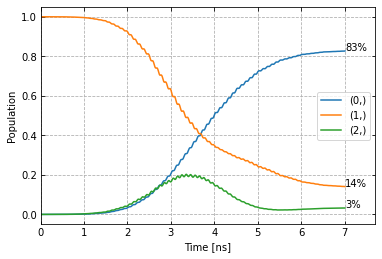

In [30]:
plot_dynamics(exp, init_state, gate_seq)

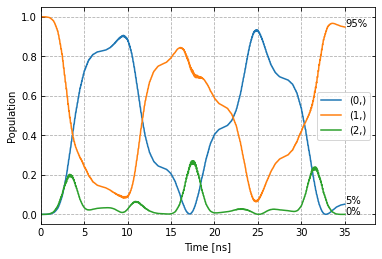

In [31]:
plot_dynamics(exp, init_state, gate_seq * 5)

Note that at this point, we only multiply already computed matrices. We don't need to solve the equations of motion again for new sequences.

To define which parameters we optimize, we write the gateset_opt_map, a nested list of tuples that identifies each parameter.

In [32]:
opt_gates = ["rx90p[0]"]
gateset_opt_map = [[("rx90p[0]", "d1", "carrier", "framechange"),]]
for envelope, sig_opt_params in zip(signal_envelopes, signals_opt_params):
    sig_name = envelope.name
    for param in sig_opt_params:
        gateset_opt_map.append([("rx90p[0]", "d1", sig_name, param),])

parameter_map.set_opt_map(gateset_opt_map)

In [33]:
parameter_map.print_parameters()

rx90p[0]-d1-carrier-framechange       : 0.000 rad 
rx90p[0]-d1-gauss0-amp                : 160.000 mV 
rx90p[0]-d1-gauss0-freq_offset        : -53.000 MHz 2pi 
rx90p[0]-d1-gauss0-xy_angle           : -444.089 arad 
rx90p[0]-d1-gauss0-delta              : -1.000  
rx90p[0]-d1-gauss0-t_final            : 7.000 ns 
rx90p[0]-d1-gauss1-amp                : 180.000 mV 
rx90p[0]-d1-gauss1-freq_offset        : -53.000 MHz 2pi 
rx90p[0]-d1-gauss1-xy_angle           : -444.089 arad 
rx90p[0]-d1-gauss1-delta              : -1.000  
rx90p[0]-d1-gauss1-t_final            : 7.000 ns 
rx90p[0]-d1-gauss2-amp                : 200.000 mV 
rx90p[0]-d1-gauss2-freq_offset        : -53.000 MHz 2pi 
rx90p[0]-d1-gauss2-xy_angle           : -444.089 arad 
rx90p[0]-d1-gauss2-delta              : -1.000  
rx90p[0]-d1-gauss2-t_final            : 7.000 ns 
rx90p[0]-d1-gauss3-amp                : 220.000 mV 
rx90p[0]-d1-gauss3-freq_offset        : -53.000 MHz 2pi 
rx90p[0]-d1-gauss3-xy_angle           : -444.089 ar

###### Control
Fidelity before optimization:

In [34]:
ideal_rx90p = parameter_map.instructions['rx90p[0]'].get_ideal_gate(dims=[qubit_lvls])

In [35]:
1 - fidelities.unitary_infid(ideal_rx90p, exp.propagators['rx90p[0]'], dims=[qubit_lvls]).numpy()[0]

0.65043872060348

In [36]:
from c3.optimizers.optimalcontrol import OptimalControl

In [37]:
import os
import tempfile

# Create a temporary directory to store logfiles, modify as needed
log_dir = os.path.join(tempfile.TemporaryDirectory().name, "c3logs")
fid_func = lambda *args, **kwargs: fidelities.sparse_unitary_infid_set(*args, 
                                                                       reg_strength=5e-2,
                                                                       loss_func_type='sumOverSqrtMax',
                                                                       **kwargs)

lbfgs_options = {"maxfun" : 10**100, 'maxiter': 10**6,  'iprint': 0,
                 'eps': 0, 'gtol': 0, 'ftol': 0, 'maxls': 10**6, 
                 'maxcor': 100}
cmaes_options = {'maxiter': 10**4}

opt = OptimalControl(
    dir_path=log_dir,
    fid_func=fid_func,
    fid_subspace=["Q1"],
    algorithm=algorithms.lbfgs,
    pmap=parameter_map,
    options=lbfgs_options,
    run_name="opt_multi_same_pulse"
)

In [38]:
exp.set_opt_gates(opt_gates)
opt.set_exp(exp)

In [39]:
opt_res = opt.optimize_controls()

C3:STATUS:Saving as: C:\Users\YONATA~1\AppData\Local\Temp\tmpzulxp3du\c3logs\opt_multi_same_pulse\2022_08_16_T_16_59_18\open_loop.c3log


C:\Users\Yonatan Gideoni\Desktop\ML4Q\c3\c3\utils\utils.py:64: UserWarning: OSError encountered while creating symlink
  warnings.warn("OSError encountered while creating symlink")
C:\Users\Yonatan Gideoni\Desktop\ML4Q\c3\c3\optimizers\optimizer.py:296: Warning: rx90p[0]-d1-gauss0-delta has no gradient. This might indicate no usage for current experiment.
  warnings.warn(
C:\Users\Yonatan Gideoni\Desktop\ML4Q\c3\c3\optimizers\optimizer.py:296: Warning: rx90p[0]-d1-gauss1-delta has no gradient. This might indicate no usage for current experiment.
  warnings.warn(
C:\Users\Yonatan Gideoni\Desktop\ML4Q\c3\c3\optimizers\optimizer.py:296: Warning: rx90p[0]-d1-gauss2-delta has no gradient. This might indicate no usage for current experiment.
  warnings.warn(
C:\Users\Yonatan Gideoni\Desktop\ML4Q\c3\c3\optimizers\optimizer.py:296: Warning: rx90p[0]-d1-gauss3-delta has no gradient. This might indicate no usage for current experiment.
  warnings.warn(
C:\Users\Yonatan Gideoni\Desktop\ML4Q\c3\c3

C:\Users\Yonatan Gideoni\Desktop\ML4Q\c3\c3\optimizers\optimizer.py:296: Warning: rx90p[0]-d1-gauss3-freq_offset has no gradient. This might indicate no usage for current experiment.
  warnings.warn(
C:\Users\Yonatan Gideoni\Desktop\ML4Q\c3\c3\optimizers\optimizer.py:296: Warning: rx90p[0]-d1-gauss3-xy_angle has no gradient. This might indicate no usage for current experiment.
  warnings.warn(
C:\Users\Yonatan Gideoni\Desktop\ML4Q\c3\c3\optimizers\optimizer.py:296: Warning: rx90p[0]-d1-gauss3-t_final has no gradient. This might indicate no usage for current experiment.
  warnings.warn(
C:\Users\Yonatan Gideoni\Desktop\ML4Q\c3\c3\optimizers\optimizer.py:296: Warning: rx90p[0]-d1-hann7-freq_offset has no gradient. This might indicate no usage for current experiment.
  warnings.warn(
C:\Users\Yonatan Gideoni\Desktop\ML4Q\c3\c3\optimizers\optimizer.py:296: Warning: rx90p[0]-d1-hann7-xy_angle has no gradient. This might indicate no usage for current experiment.
  warnings.warn(
C:\Users\Yon

In [40]:
print(f'{opt.current_best_goal:.2e}')

9.24e-02


Results for same gate sequence as before post-optimization:

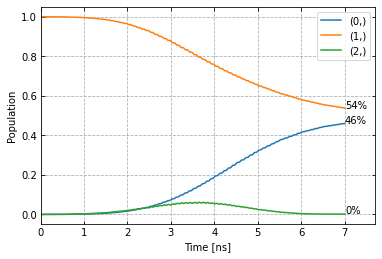

In [41]:
plot_dynamics(exp, init_state, gate_seq)

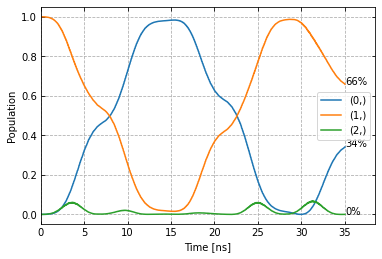

In [42]:
plot_dynamics(exp, init_state, gate_seq * 5)

Optimal parameters and fidelity post-optimization:

In [43]:
parameter_map.print_parameters()

rx90p[0]-d1-carrier-framechange       : 363.554 mrad 
rx90p[0]-d1-gauss0-amp                : 0.000 V 
rx90p[0]-d1-gauss0-freq_offset        : -52.999 MHz 2pi 
rx90p[0]-d1-gauss0-xy_angle           : -82.800 mrad 
rx90p[0]-d1-gauss0-delta              : -1.000  
rx90p[0]-d1-gauss0-t_final            : 6.976 ns 
rx90p[0]-d1-gauss1-amp                : 0.000 V 
rx90p[0]-d1-gauss1-freq_offset        : -53.000 MHz 2pi 
rx90p[0]-d1-gauss1-xy_angle           : -22.905 mrad 
rx90p[0]-d1-gauss1-delta              : -1.000  
rx90p[0]-d1-gauss1-t_final            : 6.994 ns 
rx90p[0]-d1-gauss2-amp                : 0.000 V 
rx90p[0]-d1-gauss2-freq_offset        : -52.999 MHz 2pi 
rx90p[0]-d1-gauss2-xy_angle           : -59.181 mrad 
rx90p[0]-d1-gauss2-delta              : -1.000  
rx90p[0]-d1-gauss2-t_final            : 6.989 ns 
rx90p[0]-d1-gauss3-amp                : 23.716 nV 
rx90p[0]-d1-gauss3-freq_offset        : -52.999 MHz 2pi 
rx90p[0]-d1-gauss3-xy_angle           : -90.589 mrad 
rx90p[0

In [44]:
ideal_rx90p = parameter_map.instructions['rx90p[0]'].get_ideal_gate(dims=[qubit_lvls])

In [45]:
exp.propagators['rx90p[0]'].numpy()[:2,:2]

array([[0.73059534+0.01994267j, 0.02012335-0.67858491j],
       [0.02036318-0.67821948j, 0.73289467+0.0198379j ]])

In [46]:
1 - fidelities.unitary_infid(ideal_rx90p, exp.propagators['rx90p[0]'], dims=[qubit_lvls]).numpy()[0]

0.995062914615899

How the final signal looks:

In [62]:
def plot_signal(signal_envelopes: list, n_points: int= 1000):
    t_final = max(signal_envelopes[0].params['t_final'] for env in signal_envelopes).numpy()
    signal_t = np.linspace(0, t_final, n_points)
    res_signal = np.zeros(len(signal_t), dtype=np.complex128)

    for env in signal_envelopes:
        # de-normalize the amplitude so it has units of volts
        ts = awg.create_ts(0, t_final)
        env.normalize_pulse = False
        area = env.get_shape_values(ts).numpy().sum()
        amplitude = env.params['amp'].numpy()
        real_amplitude = amplitude / area
        
        signal = env.get_shape_values(signal_t).numpy() * real_amplitude
        res_signal += signal
        
        env.normalize_pulse = True

        plt.plot(signal_t*1e9, np.real(signal), label=env.name)

    plt.plot(signal_t*1e9, np.real(res_signal), label='Resulting signal', c='k', 
             linewidth=2, linestyle='dashed')
    
    plt.title('Real part of pulses')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid()
    plt.xlabel('Time[ns]')
    plt.ylabel('Signal[V]')
    plt.xlim(0, t_final*1e9)

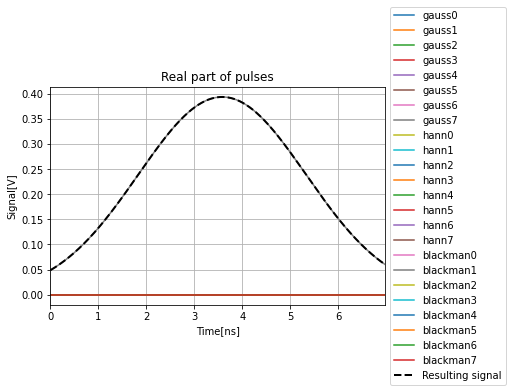

In [63]:
plot_signal(signal_envelopes)

In [49]:
print(opt_res.success)
print(opt_res.message)

True
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
